# Detect Open Doors Using Object Detection

This notebook runs an object detection model developed in LandingLens to detect if a door is open or closed. For ease of use, the notebook uses a test image, but you can customize the code to use the feed from an RTSP camera.

In [28]:
#@title Set the following variables as needed for your setup
api_key         = "land_sk_aMemWbpd41yXnQ0tXvZMh59ISgRuKNRKjJEIUHnkiH32NBJAwf"  #@param {type:"string"}
model_endpoint  =  "881e04f4-1a16-4728-b19c-a6900d0b8d98" #@param {type:"string"}


In [29]:
!pip install landingai


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Acquire an Image

In the following code cell, we simulate a camera stream by setting the `camera_url` to an image file. You can customize the code by setting the `camera_url` to the URL for a real video stream. 

Tip: For most laptops, setting `camera_url` to 0 will connect the app to your webcam.

In [1]:
from landingai.storage.data_access import fetch_from_uri

# Below are some sample images for you to try out.
img_paths = [
    fetch_from_uri("https://drive.google.com/uc?id=1hA1npgptlvdRvLGewMNRqPjfclHHOiZ9"),
    fetch_from_uri("https://drive.google.com/uc?id=1vv48yWe0_SwcgX8AgfYg9lxqQ8aNxz0I"),
    fetch_from_uri("https://drive.google.com/uc?id=14RKAe-PioJwMf6DZP0Nk03YESJ0h7jb3"),
    fetch_from_uri("https://drive.google.com/uc?id=1Q1Y6oM2_63gj35z6h8Qu3j7CVr-bfLtt"),
]

# In order to find the URL for your camera, this is a good start https://www.ispyconnect.com/cameras
# camera_url      =  "rtsp://172.25.101.151/ch0_0.h264" #@param {type:"string"}
camera_url      =  img_paths[0] # Use sample images
# camera_url      =  0 # Connect to local webcam

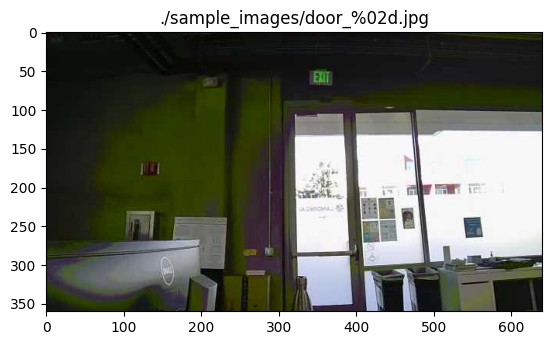

In [30]:
import cv2
from matplotlib import pyplot as plt

# Open connection to camera
vcap = cv2.VideoCapture(camera_url)

# Capture frame-by-frame
ret, frame = vcap.read()

# Convert color space to RGB
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Show the captured image
plt.imshow(frame)
plt.title(camera_url)
plt.show()

## Run Inference Using the Object Detection Model

For this example, we have trained an Object Detection Model in LandingLens that detects whether a door is open or closed. We have also deployed this model to an endpoint hosted by LandingLens.

In the following code cell, we call the `Predictor` to get the prediction result for the camera frame we captured above.

The prediction result is a list of `ObjectDetectionPrediction` instances. Each `ObjectDetectionPrediction` instance represents a predicted bounding box with the predicted confidence score and predicted class name.

In [31]:
from landingai.predict import Predictor
from landingai.visualize import overlay_predictions
        
predictor = Predictor(model_endpoint, api_key=api_key)

# Run prediction and show raw results
results = predictor.predict(frame)
display(results)

[ObjectDetectionPrediction(score=0.9365363121032715, label_name='Closed door', label_index=1, id='027ed948-c000-44b9-b6bf-4ed16ba6e81c', bboxes=(310, 92, 407, 360))]

## Visualize the Results

To visualize the predicted bounding box, we call `overlay_predictions`.

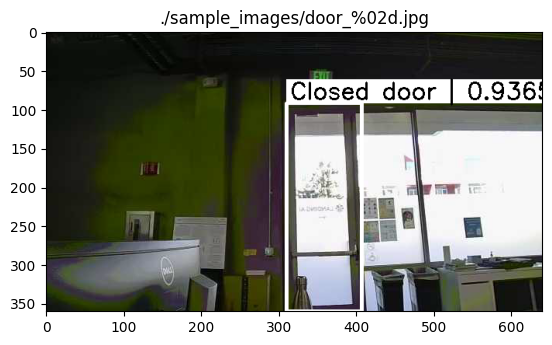

In [32]:
# Draw raw results on the original image
frame_ov = overlay_predictions(results, image=frame)
plt.imshow(frame_ov)
plt.title(camera_url)
plt.show()


## Process the Results to Determine if the Door Is Closed or Not Closed

Now that we have the predictions, we define the following rules to decide if the door is closed or not closed:

1. If there are no predictions, the door is closed.
2. If there are predictions, find the prediction with the highest confidence score. If that prediction is Open, then say that the door is not closed. If that prediction is Closed, then say that the door is closed.

The following code cell defines these rules.

In [34]:
from IPython.display import display, Markdown
# For better accuracy we look at the top detection and only claim that the door is closed if we identify it as such. If the door is partially open or fully open it will be reported as open.
if len(results) > 0:
    top_detection = max(results, key=lambda x: x.score)
    if top_detection.label_name == "Closed door":
        display(Markdown('# The door is closed'))
    else:
        display(Markdown('# The door is not closed'))
else:
    display(Markdown('# The door is not closed'))


# The door is closed